# Imports del notebook

In [1]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Variables globales

In [2]:
current_directory = os.getcwd()
print(current_directory) 

/Users/fer/Downloads/TFM


In [3]:
### GLOBAL_VARIABLES
DATA_PATH = "/Users/fer/Downloads/TFM"
FILE_NAME = "datasetsemana2.csv"

In [4]:
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

In [5]:
TRAIN_CSV_PATH

'/Users/fer/Downloads/TFM/datasetsemana2.csv'

# Funciones

In [6]:
def load_data(path_data_file):
    '''
    Loads the csv file for training.
    '''
    df = pd.read_csv(path_data_file, index_col = 0)
    
    return df

# Data Loading

In [19]:
df = load_data(path_data_file = TRAIN_CSV_PATH)
df.sample(5)

,id,item,category,department,store,store_code,region,date,unidades,event,year,yearweek,month,precio_imputado,ganancias_semana
3277983,SUPERMARKET_3_169_BOS_1,SUPERMARKET_3_169,SUPERMARKET,SUPERMARKET_3,South_End,BOS_1,Boston,2015-12-20,9,0,2015,201550,12,4.7760,42.9840
2544480,SUPERMARKET_2_030_NYC_1,SUPERMARKET_2_030,SUPERMARKET,SUPERMARKET_2,Greenwich_Village,NYC_1,New York,2013-07-21,22,0,2013,201328,7,5.3760,118.2720
1393590,HOME_&_GARDEN_1_462_NYC_2,HOME_&_GARDEN_1_462,HOME_&_GARDEN,HOME_&_GARDEN_1,Harlem,NYC_2,New York,2014-01-05,10,1,2014,201400,1,2.9625,29.6250
1112204,HOME_&_GARDEN_1_253_BOS_1,HOME_&_GARDEN_1_253,HOME_&_GARDEN,HOME_&_GARDEN_1,South_End,BOS_1,Boston,2016-04-03,0,0,2016,201613,4,4.3375,0.0000
124684,ACCESORIES_1_094_BOS_2,ACCESORIES_1_094,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston,2012-04-15,8,0,2012,201215,4,17.2501,138.0008


In [20]:
#Tipo de datos del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4177107 entries, 0 to 4177106
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                object 
 1   item              object 
 2   category          object 
 3   department        object 
 4   store             object 
 5   store_code        object 
 6   region            object 
 7   date              object 
 8   unidades          int64  
 9   event             int64  
 10  year              int64  
 11  yearweek          int64  
 12  month             int64  
 13  precio_imputado   float64
 14  ganancias_semana  float64
dtypes: float64(2), int64(5), object(8)
memory usage: 509.9+ MB


In [21]:
#Veamos cuantas series temporales tiene el dataset
df[['department', 'store_code', 'item']].nunique()

department       7
store_code      10
item          3049
dtype: int64

In [22]:
df[['department', 'store_code', 'item']].drop_duplicates().shape[0]

30490

In [23]:
df['id'].nunique()

30490

In [24]:
#Identificamos la fecha min y max
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()
print(MIN_DATE)
print(MAX_DATE)

2011-01-30
2016-04-24


# Agrupación de las ventas por semana

In [25]:
df.sample(5)

,id,item,category,department,store,store_code,region,date,unidades,event,year,yearweek,month,precio_imputado,ganancias_semana
1140325,HOME_&_GARDEN_1_274_NYC_3,HOME_&_GARDEN_1_274,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2013-05-05,0,0,2013,201317,5,6.175,0.000
3162018,SUPERMARKET_3_084_BOS_3,SUPERMARKET_3_084,SUPERMARKET,SUPERMARKET_3,Back_Bay,BOS_3,Boston,2013-06-02,0,0,2013,201321,6,2.376,0.000
2444628,SUPERMARKET_1_176_NYC_1,SUPERMARKET_1_176,SUPERMARKET,SUPERMARKET_1,Greenwich_Village,NYC_1,New York,2013-03-03,7,0,2013,201308,3,3.888,27.216
2486490,SUPERMARKET_1_206_PHI_3,SUPERMARKET_1_206,SUPERMARKET,SUPERMARKET_1,Queen_Village,PHI_3,Philadelphia,2014-02-16,3,0,2014,201406,2,2.736,8.208
3404255,SUPERMARKET_3_261_NYC_1,SUPERMARKET_3_261,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2012-02-26,4,0,2012,201208,2,5.376,21.504


A continuación vamos a agrupar las ventas diarias por semana, en función de cada shop_id e item_id (groupby).

Dado que vamos a entrenar nuestro modelo con variables semanales, aprovechamos la operación para constuir un total de 3 variables:

Ingresos totales (precio x cantidad)
Semanas únicas que tuvieron ventas
Total transacciones de la semana

In [26]:
df["revenue"] = df["precio_imputado"] * df["unidades"]
df["semanas_unicas_con_ventas"] = df["date"]
df["total_transactions"] = df["unidades"]

In [27]:
df['date'] = pd.to_datetime(df['date'])

In [28]:
df.set_index('date', inplace=True)

<Axes: title={'center': 'Weekly Sales'}, xlabel='date'>

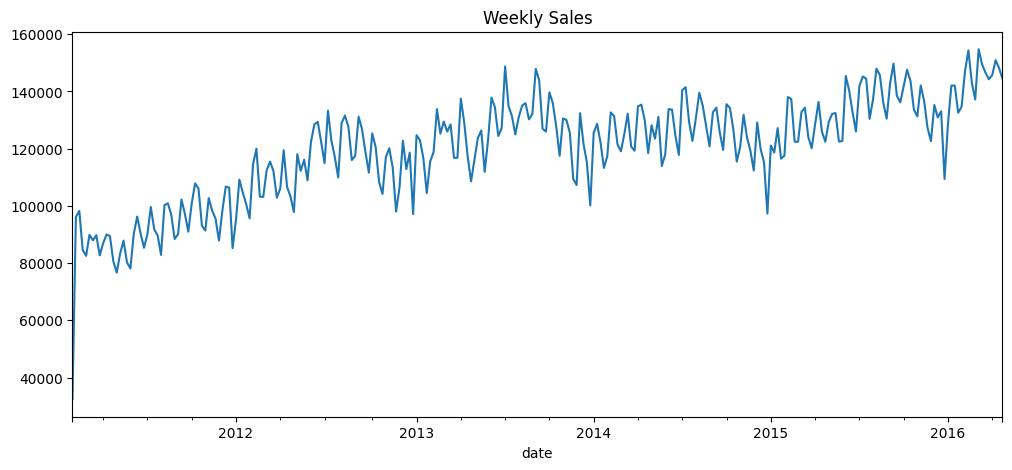

In [29]:
df.resample('W')['unidades'].sum().plot(figsize=(12, 5), title='Weekly Sales')

In [30]:
df_week_agg = df.groupby(["id"]).resample("W").agg(
    {
        "unidades":np.sum,
        "semanas_unicas_con_ventas":lambda dates: len(set(dates)),
        "total_transactions":len,
    }
).reset_index()

In [31]:
df_week_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8293558 entries, 0 to 8293557
Data columns (total 5 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   id                         object        
 1   date                       datetime64[ns]
 2   unidades                   int64         
 3   semanas_unicas_con_ventas  int64         
 4   total_transactions         int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 316.4+ MB


In [34]:
df_week_agg["CHECK"] = df_week_agg["semanas_unicas_con_ventas"] == df_week_agg["total_transactions"]

In [35]:
df_week_agg.sample(5)

,id,date,unidades,semanas_unicas_con_ventas,total_transactions,CHECK
6401718,SUPERMARKET_3_129_NYC_3,2013-01-06,0,1,1,True
4455418,SUPERMARKET_1_027_PHI_3,2014-04-13,0,0,0,True
6389055,SUPERMARKET_3_124_PHI_2,2015-04-19,0,0,0,True
2120957,HOME_&_GARDEN_1_219_PHI_1,2012-04-01,0,0,0,True
6021748,SUPERMARKET_2_387_PHI_2,2011-10-09,0,1,1,True


In [36]:
df_week_agg[df_week_agg["CHECK"] == False]

,id,date,unidades,semanas_unicas_con_ventas,total_transactions,CHECK


In [37]:
df['unidades'].sum()

32822341

In [38]:
df_week_agg['unidades'].sum()

32822341

In [39]:
df_week_agg = df_week_agg.rename(columns={'unidades': 'ventas_semanales'})


# Comprobación de si tenemos todas las semanas en nuestro dataset

In [40]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [41]:
start_date = pd.to_datetime(MIN_DATE)
end_date = pd.to_datetime(MAX_DATE)
print(start_date)
print(end_date)

2011-01-30 00:00:00
2016-04-24 00:00:00


In [42]:
#Verificamos cuantas semanas debemos tener notificadas
# Calcula la diferencia en días entre las fechas
import math

diferencia = end_date - start_date
dias = diferencia.days

# Convierte los días en semanas, redondeando hacia arriba
semanas = math.ceil(dias / 7)+1
semanas

274

In [43]:
check_weeks = df_week_agg.groupby("id").size()
check_weeks.sample(3)

id
SUPERMARKET_2_110_PHI_1      274
HOME_&_GARDEN_2_120_PHI_2    271
SUPERMARKET_3_479_NYC_3      274
dtype: int64

In [44]:
check_weeks[check_weeks != 274].shape

(22848,)

In [45]:
check_weeks.shape

(30490,)

Tenemos 22848 series sin todos los meses informados

Como la predición la tenemos que realizar de 4 semanas, vamos a ir añadiendo las semanas de una en una

In [46]:
# generamos un rango con todas las fechas incluídas en el predict
DATE_PREDICTION = np.datetime64("2016-05-01")
date_range = pd.date_range(MIN_DATE, DATE_PREDICTION, freq = "W")
date_range

DatetimeIndex(['2011-01-30', '2011-02-06', '2011-02-13', '2011-02-20',
               '2011-02-27', '2011-03-06', '2011-03-13', '2011-03-20',
               '2011-03-27', '2011-04-03',
               ...
               '2016-02-28', '2016-03-06', '2016-03-13', '2016-03-20',
               '2016-03-27', '2016-04-03', '2016-04-10', '2016-04-17',
               '2016-04-24', '2016-05-01'],
              dtype='datetime64[ns]', length=275, freq='W-SUN')

In [47]:
# sacamos todas las combinaciones únicas que tenemos en nuestro dataframe (30490 combinaciones, una por cada serie temporal)
unique_id = sorted(df_week_agg["id"].unique())
unique_id[:3]

['ACCESORIES_1_001_BOS_1', 'ACCESORIES_1_001_BOS_2', 'ACCESORIES_1_001_BOS_3']

In [48]:
len(unique_id)

30490

Generamos todas las combinaciones entre semanas e unique_id.

Es decir, necesitamos sacar un producto cartesiano.

In [49]:
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["date", "id"])
len(cartesian_product)

8384750

In [50]:
# 8384750 son 275 semanas por todas las combinaciones de unique_id
275 * 30490


8384750

Cruzamos nuestro producto cartesiano con el dataframe agrupado por semanas y que contiene las ventas históricas.

In [51]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

print(full_df.shape)

full_df = pd.merge(full_df, df_week_agg, on = ['date','id'], how = 'left')

print(full_df.shape)

(8384750, 2)
(8384750, 6)


In [52]:
full_df.sample(5)

,date,id,ventas_semanales,semanas_unicas_con_ventas,total_transactions,CHECK
6874271,2015-05-24,HOME_&_GARDEN_2_307_BOS_2,0.0,0.0,0.0,True
6208849,2014-12-21,SUPERMARKET_2_111_PHI_3,0.0,0.0,0.0,True
903807,2011-08-21,SUPERMARKET_2_133_PHI_1,0.0,1.0,1.0,True
1658827,2012-02-12,HOME_&_GARDEN_2_140_PHI_1,2.0,1.0,1.0,True
3826460,2013-06-23,HOME_&_GARDEN_2_426_BOS_1,0.0,0.0,0.0,True


In [53]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384750 entries, 0 to 8384749
Data columns (total 6 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   date                       datetime64[ns]
 1   id                         object        
 2   ventas_semanales           float64       
 3   semanas_unicas_con_ventas  float64       
 4   total_transactions         float64       
 5   CHECK                      object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 383.8+ MB


In [54]:
df = df.reset_index(drop=True)
add_info = df[
    ["id", "item", "category", "department", "store", "store_code", "region"]
].drop_duplicates()

add_info.head(3)

,id,item,category,department,store,store_code,region
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston
140,ACCESORIES_1_001_BOS_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston
285,ACCESORIES_1_001_BOS_3,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Back_Bay,BOS_3,Boston


In [55]:
add_info.shape

(30490, 7)

In [56]:
print(full_df.shape)

full_df = pd.merge(
    left = full_df,
    right = add_info,
    how = "left",
    on = "id"
)

print(full_df.shape)

(8384750, 6)
(8384750, 12)


# Data imputation

In [57]:
full_df.drop(["CHECK"], axis = 1, inplace = True)

In [58]:
full_df.isnull().sum()

date                             0
id                               0
ventas_semanales             91192
semanas_unicas_con_ventas    91192
total_transactions           91192
item                             0
category                         0
department                       0
store                            0
store_code                       0
region                           0
dtype: int64

In [60]:
full_df["ventas_semanales"].fillna(0, inplace = True)
full_df["semanas_unicas_con_ventas"].fillna(0, inplace = True)
full_df["total_transactions"].fillna(0, inplace = True)

# 1-EDA DSMarket

In [61]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2)
    plot_pacf(x = y, ax = ax3)

    plt.suptitle(t = title, fontsize = 20)

In [62]:
y = full_df.set_index("date").resample("W")["ventas_semanales"].sum()

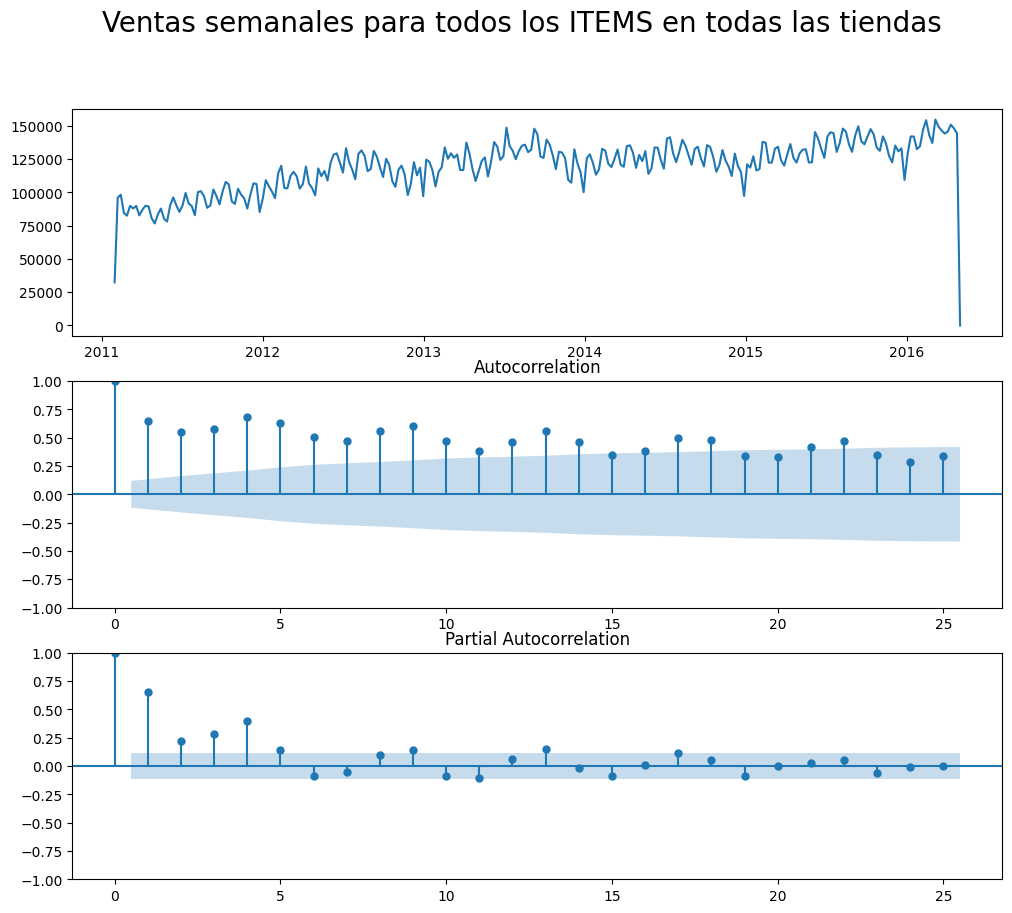

In [63]:
plot_ts_acf_pacf(y = y, title = "Ventas semanales para todos los ITEMS en todas las tiendas");

Para resolver el problema que se nos plantea: 30490 Series Temporales diferentes tendríamos que entrenar 30490 ARIMAs. En cambio, con el algoritmo de XGBoost podríamos entrenar 1 único modelo.

Ahora bien, al contrario que ARIMA (que internamente construye las variables necesarias), para XGBoost debemos ser explícitos y suministrarle todas y cada una de las variables necesarias.

Del gráfico anterior ya podemos observar que las variables de lags pueden ser muy relevantes.

# 2- EDA Top Tiendas

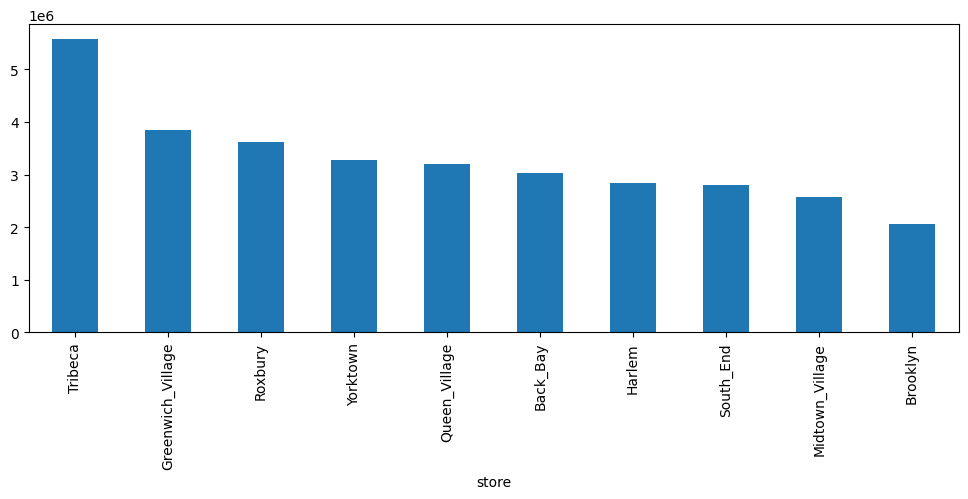

In [64]:
(
    full_df.
    groupby(["store"])
    ["ventas_semanales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

# 3- EDA Top Region

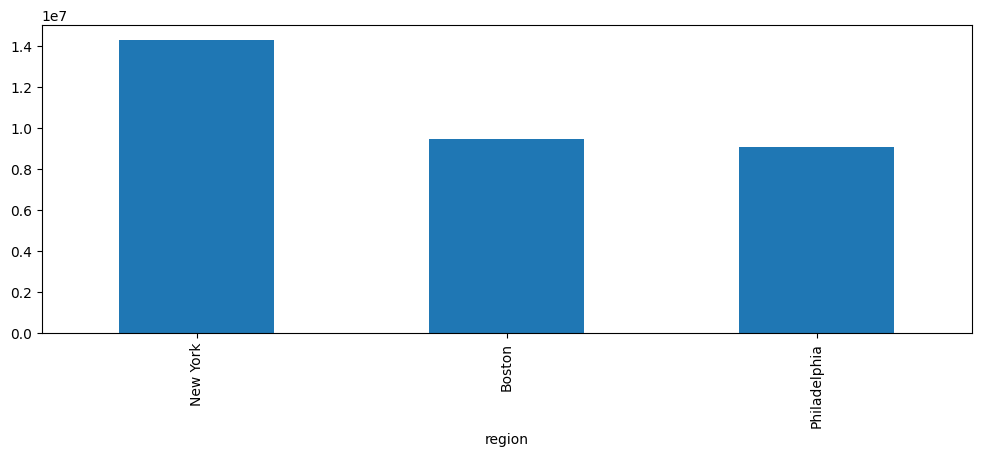

In [65]:
(
    full_df.
    groupby(["region"])
    ["ventas_semanales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

# 4-EDA Top Categoria

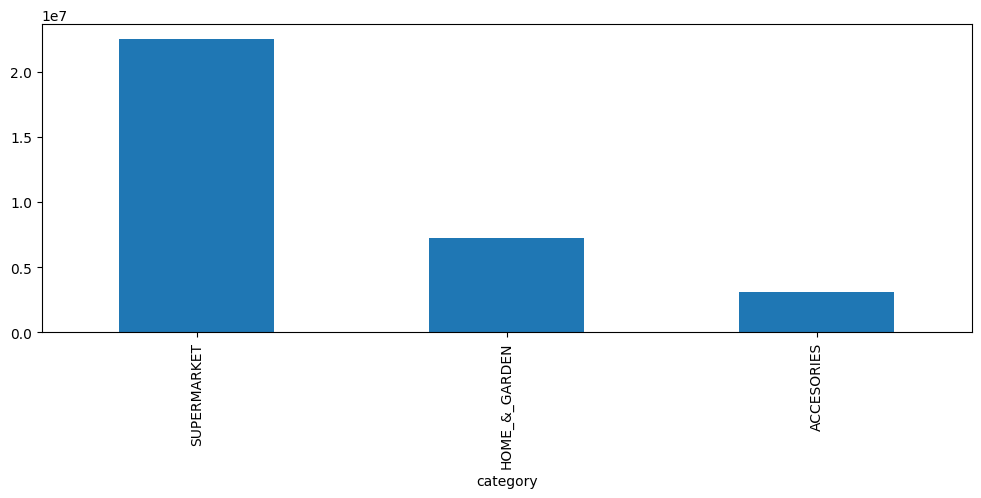

In [66]:
(
    full_df.
    groupby(["category"])
    ["ventas_semanales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

# 5-EDA Top ITEM

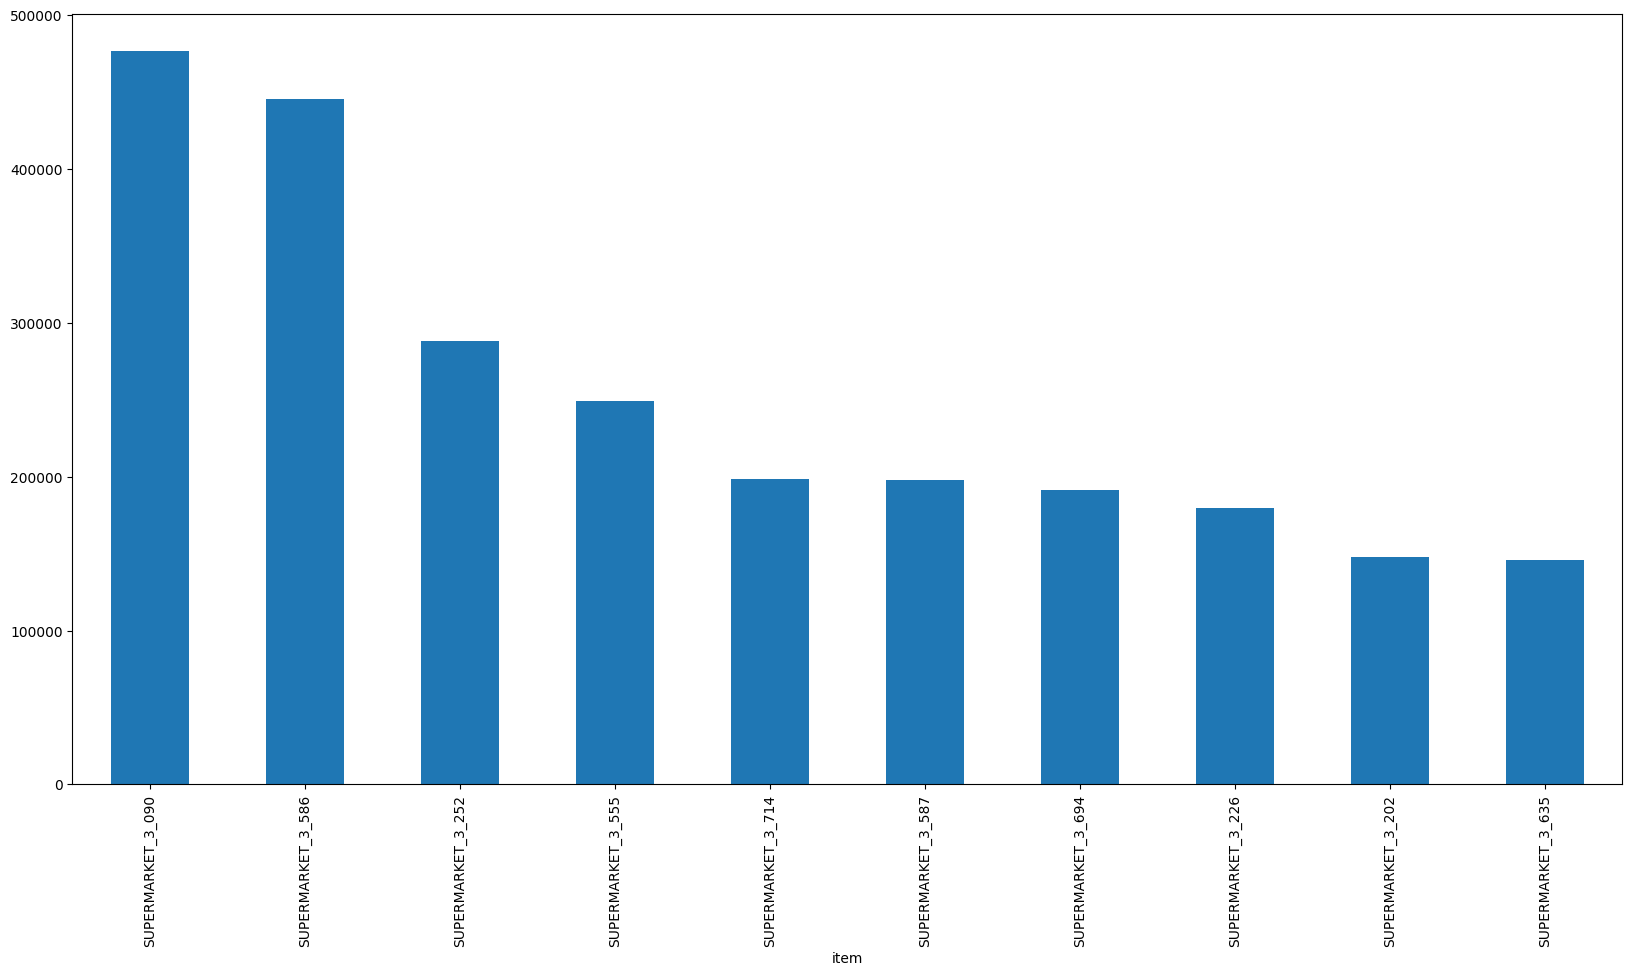

In [67]:
(
    full_df
    .groupby(["item"])["ventas_semanales"].sum()
    .sort_values(ascending = False)
    .head(10)
    .plot(kind = "bar", figsize = (20, 10))
);

# Build Time Series Features (CORE IDEA)

## Lag Features

In [68]:
copy_full_df = full_df.copy()

In [69]:
full_df.sample(5).T

,3731557,6251484,528470,5029750,369651
date,2013-06-02 00:00:00,2015-01-04 00:00:00,2011-05-29 00:00:00,2014-03-23 00:00:00,2011-04-24 00:00:00
id,HOME_&_GARDEN_2_081_PHI_1,ACCESORIES_1_108_NYC_2,HOME_&_GARDEN_1_459_BOS_1,SUPERMARKET_3_716_BOS_1,ACCESORIES_1_386_BOS_2
ventas_semanales,0.0,2.0,0.0,0.0,0.0
semanas_unicas_con_ventas,0.0,1.0,0.0,0.0,0.0
total_transactions,0.0,1.0,0.0,0.0,0.0
item,HOME_&_GARDEN_2_081,ACCESORIES_1_108,HOME_&_GARDEN_1_459,SUPERMARKET_3_716,ACCESORIES_1_386
category,HOME_&_GARDEN,ACCESORIES,HOME_&_GARDEN,SUPERMARKET,ACCESORIES
department,HOME_&_GARDEN_2,ACCESORIES_1,HOME_&_GARDEN_1,SUPERMARKET_3,ACCESORIES_1
store,Midtown_Village,Harlem,South_End,South_End,Roxbury
store_code,PHI_1,NYC_2,BOS_1,BOS_1,BOS_2


In [70]:
def build_ts_vars(full_df, gb_list, target_column, agg_func, agg_func_name, verbose = True):
    
    assert gb_list[0] == "date", "Primer elemento que debe ser la fecha"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    
    if verbose: print(new_name)

    gb_df_ = full_df.groupby(gb_list)[target_column].apply(agg_func).to_frame().reset_index().rename(
        columns = {
            target_column : new_name
        }
    )

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    return gb_df_

In [71]:
GB_LIST_SHOP_ID = ["date", "id"]
TARGET_COLUMN = "ventas_semanales"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id = build_ts_vars(
    full_df = full_df,
    gb_list = GB_LIST_SHOP_ID,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_shop_id.sample(10)

date_id_ventas_semanales_SUM


,date,id,date_id_ventas_semanales_SUM,date_id_ventas_semanales_SUM_LAG1
1054185,2011-09-25,SUPERMARKET_1_143_NYC_3,0.0,0.0
7087029,2015-07-12,HOME_&_GARDEN_2_239_PHI_3,11.0,0.0
4261415,2013-09-29,SUPERMARKET_3_106_NYC_3,8.0,0.0
5352398,2014-06-08,SUPERMARKET_1_054_PHI_2,0.0,8.0
6747894,2015-04-26,HOME_&_GARDEN_1_405_NYC_2,0.0,0.0
3971702,2013-07-28,HOME_&_GARDEN_1_241_BOS_3,0.0,0.0
4556767,2013-12-08,HOME_&_GARDEN_2_280_PHI_1,0.0,0.0
7560831,2015-10-25,SUPERMARKET_3_759_BOS_2,7.0,5.0
7474303,2015-10-11,ACCESORIES_2_010_NYC_1,0.0,0.0
3439890,2013-03-24,SUPERMARKET_3_277_BOS_1,0.0,0.0


In [72]:
#Verificacion
sample_df = vars_ts_shop_id[vars_ts_shop_id['id'].str[-5:]=='NYC_4'].copy()
sample_df = sample_df[vars_ts_shop_id['id'].str[-9:-6]=='001'].copy()
sample_df = sample_df[vars_ts_shop_id['id'].str.slice(start=0, stop=-10)=='ACCESORIES_1'].copy()
sample_df['date'] = pd.to_datetime(sample_df['date'], format='%Y-%m-%d')
sample_df.sort_values(by=['date'])

/var/folders/_6/x9wbm2015gldhqsf7z2bp2vh0000gn/T/ipykernel_83371/2594090485.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_df = sample_df[vars_ts_shop_id['id'].str[-9:-6]=='001'].copy()
/var/folders/_6/x9wbm2015gldhqsf7z2bp2vh0000gn/T/ipykernel_83371/2594090485.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_df = sample_df[vars_ts_shop_id['id'].str.slice(start=0, stop=-10)=='ACCESORIES_1'].copy()


,date,id,date_id_ventas_semanales_SUM,date_id_ventas_semanales_SUM_LAG1
6,2011-01-30,ACCESORIES_1_001_NYC_4,0.0,NaN
30496,2011-02-06,ACCESORIES_1_001_NYC_4,0.0,0.0
60986,2011-02-13,ACCESORIES_1_001_NYC_4,0.0,0.0
91476,2011-02-20,ACCESORIES_1_001_NYC_4,0.0,0.0
121966,2011-02-27,ACCESORIES_1_001_NYC_4,0.0,0.0
...,...,...,...,...
8232306,2016-04-03,ACCESORIES_1_001_NYC_4,0.0,6.0
8262796,2016-04-10,ACCESORIES_1_001_NYC_4,0.0,0.0
8293286,2016-04-17,ACCESORIES_1_001_NYC_4,4.0,0.0
8323776,2016-04-24,ACCESORIES_1_001_NYC_4,6.0,4.0


## Promedio móvil

In [73]:
vars_ts_shop_id.sample(10)

,date,id,date_id_ventas_semanales_SUM,date_id_ventas_semanales_SUM_LAG1
93710,2011-02-20,ACCESORIES_1_232_BOS_1,0.0,0.0
3765628,2013-06-09,HOME_&_GARDEN_2_440_PHI_2,0.0,0.0
4502912,2013-11-24,SUPERMARKET_2_262_BOS_3,0.0,0.0
4573003,2013-12-08,SUPERMARKET_3_778_NYC_1,2.0,8.0
899469,2011-08-21,HOME_&_GARDEN_2_430_PHI_3,0.0,0.0
4859931,2014-02-16,HOME_&_GARDEN_2_106_BOS_2,0.0,0.0
2957859,2012-12-09,ACCESORIES_1_033_PHI_3,0.0,0.0
8041620,2016-02-14,SUPERMARKET_3_050_BOS_1,0.0,0.0
3813967,2013-06-23,ACCESORIES_1_279_PHI_1,0.0,0.0
7188442,2015-08-02,SUPERMARKET_3_105_BOS_3,2.0,0.0


In [74]:
#Nos aseguramos que los datos esta ordenados por fecha
vars_ts_shop_id['date'] = pd.to_datetime(vars_ts_shop_id['date'])
vars_ts_shop_id = vars_ts_shop_id.sort_values('date')

In [75]:
vars_ts_shop_id['rolling_mean_4w'] = vars_ts_shop_id.groupby('id')['date_id_ventas_semanales_SUM'].transform(lambda x: x.rolling(4).mean())

In [76]:
vars_ts_shop_id['rolling_mean_6m'] = vars_ts_shop_id.groupby('id')['date_id_ventas_semanales_SUM'].transform(lambda x: x.rolling(24).mean())

## Desviación estándar móvil 

In [77]:
sample_df.sample(10)

,date,id,date_id_ventas_semanales_SUM,date_id_ventas_semanales_SUM_LAG1
4390566,2013-11-03,ACCESORIES_1_001_NYC_4,0.0,4.0
2103816,2012-05-27,ACCESORIES_1_001_NYC_4,0.0,0.0
5701636,2014-08-31,ACCESORIES_1_001_NYC_4,4.0,0.0
3994196,2013-08-04,ACCESORIES_1_001_NYC_4,0.0,0.0
3506356,2013-04-14,ACCESORIES_1_001_NYC_4,0.0,0.0
7409076,2015-09-27,ACCESORIES_1_001_NYC_4,2.0,0.0
6707806,2015-04-19,ACCESORIES_1_001_NYC_4,0.0,0.0
2988026,2012-12-16,ACCESORIES_1_001_NYC_4,0.0,0.0
4817426,2014-02-09,ACCESORIES_1_001_NYC_4,0.0,6.0
6585846,2015-03-22,ACCESORIES_1_001_NYC_4,0.0,0.0


In [78]:
vars_ts_shop_id['rolling_std_4w'] = vars_ts_shop_id.groupby('id')['date_id_ventas_semanales_SUM'].transform(lambda x: x.rolling(4).std())

In [79]:
vars_ts_shop_id['rolling_std_6m'] = vars_ts_shop_id.groupby('id')['date_id_ventas_semanales_SUM'].transform(lambda x: x.rolling(24).std())

In [80]:
sample_df.sample(10)

,date,id,date_id_ventas_semanales_SUM,date_id_ventas_semanales_SUM_LAG1
6555356,2015-03-15,ACCESORIES_1_001_NYC_4,0.0,0.0
4817426,2014-02-09,ACCESORIES_1_001_NYC_4,0.0,6.0
2408716,2012-08-05,ACCESORIES_1_001_NYC_4,0.0,0.0
1158626,2011-10-23,ACCESORIES_1_001_NYC_4,0.0,0.0
6585846,2015-03-22,ACCESORIES_1_001_NYC_4,0.0,0.0
5671146,2014-08-24,ACCESORIES_1_001_NYC_4,0.0,1.0
274416,2011-04-03,ACCESORIES_1_001_NYC_4,0.0,0.0
30496,2011-02-06,ACCESORIES_1_001_NYC_4,0.0,0.0
7927406,2016-01-24,ACCESORIES_1_001_NYC_4,0.0,0.0
182946,2011-03-13,ACCESORIES_1_001_NYC_4,0.0,0.0


# Join TS Features

En este apartado, hacemos el merge del full_df con las variables auxiliares.

Debemos controlar muy bien el merge, para no provocar un cartesiano.

In [81]:
rows_before_merge = full_df.shape[0]
print(f"Shape antes del merge {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id, on = GB_LIST_SHOP_ID, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape despues del merge {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "Hemos generado un producto cartesiano!"

Shape antes del merge 8384750
Shape despues del merge 8384750


In [82]:
full_df.to_pickle("FULL_DF_ALL_FEATURES_DSMARKET_WEEK_1.pkl")

# Train Test Split

In [83]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384750 entries, 0 to 8384749
Data columns (total 17 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   date                               datetime64[ns]
 1   id                                 object        
 2   ventas_semanales                   float64       
 3   semanas_unicas_con_ventas          float64       
 4   total_transactions                 float64       
 5   item                               object        
 6   category                           object        
 7   department                         object        
 8   store                              object        
 9   store_code                         object        
 10  region                             object        
 11  date_id_ventas_semanales_SUM       float64       
 12  date_id_ventas_semanales_SUM_LAG1  float64       
 13  rolling_mean_4w                    float64       
 14  ro

In [84]:
full_df.sample(10)

,date,id,ventas_semanales,semanas_unicas_con_ventas,total_transactions,item,category,department,store,store_code,region,date_id_ventas_semanales_SUM,date_id_ventas_semanales_SUM_LAG1,rolling_mean_4w,rolling_mean_6m,rolling_std_4w,rolling_std_6m
3347448,2013-03-03,SUPERMARKET_3_179_PHI_2,3.0,1.0,1.0,SUPERMARKET_3_179,SUPERMARKET,SUPERMARKET_3,Yorktown,PHI_2,Philadelphia,3.0,0.0,2.50,1.125000,2.081666,1.454005
4959481,2014-03-09,SUPERMARKET_2_184_BOS_2,43.0,1.0,1.0,SUPERMARKET_2_184,SUPERMARKET,SUPERMARKET_2,Roxbury,BOS_2,Boston,43.0,0.0,10.75,1.791667,21.500000,8.777338
5416857,2014-06-22,SUPERMARKET_2_186_PHI_1,2.0,1.0,1.0,SUPERMARKET_2_186,SUPERMARKET,SUPERMARKET_2,Midtown_Village,PHI_1,Philadelphia,2.0,2.0,1.75,0.375000,1.258306,0.875388
6208166,2014-12-21,SUPERMARKET_2_042_NYC_4,5.0,1.0,1.0,SUPERMARKET_2_042,SUPERMARKET,SUPERMARKET_2,Brooklyn,NYC_4,New York,5.0,8.0,4.75,1.125000,3.403430,2.364824
6664248,2015-04-05,SUPERMARKET_1_133_PHI_2,0.0,0.0,0.0,SUPERMARKET_1_133,SUPERMARKET,SUPERMARKET_1,Yorktown,PHI_2,Philadelphia,0.0,0.0,4.00,2.875000,8.000000,5.202946
8053903,2016-02-21,ACCESORIES_2_039_NYC_1,0.0,0.0,0.0,ACCESORIES_2_039,ACCESORIES,ACCESORIES_2,Greenwich_Village,NYC_1,New York,0.0,0.0,0.75,0.375000,1.500000,0.769670
3218875,2013-02-03,SUPERMARKET_1_133_NYC_3,1.0,1.0,1.0,SUPERMARKET_1_133,SUPERMARKET,SUPERMARKET_1,Tribeca,NYC_3,New York,1.0,2.0,1.25,3.291667,0.957427,7.601368
4056364,2013-08-18,ACCESORIES_1_124_NYC_2,9.0,1.0,1.0,ACCESORIES_1_124,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,New York,9.0,10.0,7.00,4.333333,4.690416,4.650074
6391292,2015-02-01,SUPERMARKET_2_061_BOS_3,0.0,0.0,0.0,SUPERMARKET_2_061,SUPERMARKET,SUPERMARKET_2,Back_Bay,BOS_3,Boston,0.0,10.0,7.00,6.416667,8.717798,7.586697
4931215,2014-03-02,SUPERMARKET_3_007_NYC_3,87.0,1.0,1.0,SUPERMARKET_3_007,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,87.0,0.0,44.25,84.333333,51.110175,79.873088


In [85]:
full_df.isnull().sum()

date                                      0
id                                        0
ventas_semanales                          0
semanas_unicas_con_ventas                 0
total_transactions                        0
item                                      0
category                                  0
department                                0
store                                     0
store_code                                0
region                                    0
date_id_ventas_semanales_SUM              0
date_id_ventas_semanales_SUM_LAG1     30490
rolling_mean_4w                       91470
rolling_mean_6m                      701270
rolling_std_4w                        91470
rolling_std_6m                       701270
dtype: int64

In [86]:
full_df = pd.read_pickle("FULL_DF_ALL_FEATURES_DSMARKET_WEEK_1.pkl")
#full_df["ventas_semanales"] = np.clip(full_df["ventas_semanales"], 0, 30)

In [87]:
full_df = full_df.set_index(['item','store_code', 'date'])

In [88]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8384750 entries, ('ACCESORIES_1_001', 'BOS_1', Timestamp('2011-01-30 00:00:00')) to ('SUPERMARKET_3_827', 'PHI_3', Timestamp('2016-05-01 00:00:00'))
Data columns (total 14 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   id                                 object 
 1   ventas_semanales                   float64
 2   semanas_unicas_con_ventas          float64
 3   total_transactions                 float64
 4   category                           object 
 5   department                         object 
 6   store                              object 
 7   region                             object 
 8   date_id_ventas_semanales_SUM       float64
 9   date_id_ventas_semanales_SUM_LAG1  float64
 10  rolling_mean_4w                    float64
 11  rolling_mean_6m                    float64
 12  rolling_std_4w                     float64
 13  rolling_std_6m                     float64


In [91]:
COLUMNS_TO_DROP = [
    'id',
    'semanas_unicas_con_ventas',
    'total_transactions',
    'store',
    'category',
    'region',
    'department',
    'date_id_ventas_semanales_SUM'
    #,
    #'rolling_mean_4w',
    #'rolling_mean_6m',
    #'rolling_std_4w',
    #'rolling_std_6m'
]

full_df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [92]:
full_df.sample(5)


,,,ventas_semanales,date_id_ventas_semanales_SUM_LAG1,rolling_mean_4w,rolling_mean_6m,rolling_std_4w,rolling_std_6m
item,store_code,date,,,,,,
ACCESORIES_1_324,PHI_2,2012-03-11,1.0,0.0,1.00,0.875000,1.414214,1.075922
HOME_&_GARDEN_2_451,NYC_4,2016-01-31,0.0,0.0,0.25,0.958333,0.500000,1.301476
ACCESORIES_2_091,PHI_2,2014-12-28,2.0,0.0,3.00,1.791667,2.943920,2.686183
HOME_&_GARDEN_2_414,NYC_4,2011-03-13,0.0,0.0,0.00,NaN,0.000000,NaN
SUPERMARKET_2_010,NYC_2,2014-01-26,0.0,0.0,0.00,0.000000,0.000000,0.000000


In [93]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8384750 entries, ('ACCESORIES_1_001', 'BOS_1', Timestamp('2011-01-30 00:00:00')) to ('SUPERMARKET_3_827', 'PHI_3', Timestamp('2016-05-01 00:00:00'))
Data columns (total 6 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   ventas_semanales                   float64
 1   date_id_ventas_semanales_SUM_LAG1  float64
 2   rolling_mean_4w                    float64
 3   rolling_mean_6m                    float64
 4   rolling_std_4w                     float64
 5   rolling_std_6m                     float64
dtypes: float64(6)
memory usage: 423.9+ MB


In [94]:
full_df.sort_index(inplace=True) # Ordenamos data set por fecha

In [95]:
# Calcula la fecha 6 meses atrás desde la última fecha en los datos
six_months_ago = full_df.index.get_level_values('date').max() - pd.DateOffset(months=6)

# Calcula la fecha de hace una semana desde la última fecha en los datos
one_week_ago = full_df.index.get_level_values('date').max() - pd.DateOffset(weeks=1)

# Divide los datos en entrenamiento y validación
# El conjunto de entrenamiento ahora no incluye la última semana
train_df = full_df[(full_df.index.get_level_values('date') >= six_months_ago) & 
                   (full_df.index.get_level_values('date') < one_week_ago)] 

# El conjunto de validación es ahora la penúltima semana
valid_df = full_df[full_df.index.get_level_values('date') == one_week_ago]

# Model Train

Entrenamos nuestro modelo de Machine Learning.



In [96]:
model = xgb.XGBRegressor(eval_metric = "rmse", early_stopping_rounds = 10, seed = 175)

In [97]:
model_name = str(model).split("(")[0]
day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

In [98]:
X_train = train_df.drop(['ventas_semanales'], axis=1)
Y_train = train_df['ventas_semanales']
X_valid = valid_df.drop(['ventas_semanales'], axis=1)
Y_valid = valid_df['ventas_semanales']

In [99]:
# Entrenamos el modelo
#model = xgb.XGBRegressor(objective='reg:squarederror')

#X_train = train_df.drop(['ventas_semanales'], axis=1)
#y_train = train_df['ventas_semanales']

#model.fit(X_train, y_train)

model.fit(X_train, Y_train, 
    eval_set = [(X_train, Y_train), (X_valid, Y_valid)], 
    verbose = True)

[0]	validation_0-rmse:13.38215	validation_1-rmse:13.26470
[1]	validation_0-rmse:11.72610	validation_1-rmse:11.43908
[2]	validation_0-rmse:10.76102	validation_1-rmse:10.49646
[3]	validation_0-rmse:10.21847	validation_1-rmse:10.04524
[4]	validation_0-rmse:9.89451	validation_1-rmse:9.76065
[5]	validation_0-rmse:9.70953	validation_1-rmse:9.60503
[6]	validation_0-rmse:9.55520	validation_1-rmse:9.57824
[7]	validation_0-rmse:9.46608	validation_1-rmse:9.51927
[8]	validation_0-rmse:9.41223	validation_1-rmse:9.55468
[9]	validation_0-rmse:9.33951	validation_1-rmse:9.54192
[10]	validation_0-rmse:9.31757	validation_1-rmse:9.52702
[11]	validation_0-rmse:9.23035	validation_1-rmse:9.49846
[12]	validation_0-rmse:9.17320	validation_1-rmse:9.50784
[13]	validation_0-rmse:9.15256	validation_1-rmse:9.53091
[14]	validation_0-rmse:9.09130	validation_1-rmse:9.55877
[15]	validation_0-rmse:9.06514	validation_1-rmse:9.52820
[16]	validation_0-rmse:9.04643	validation_1-rmse:9.52862
[17]	validation_0-rmse:9.01494	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [100]:
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2023_07_14_11_10_41.dat


# Model Evaluation (CORE IDEA)¶


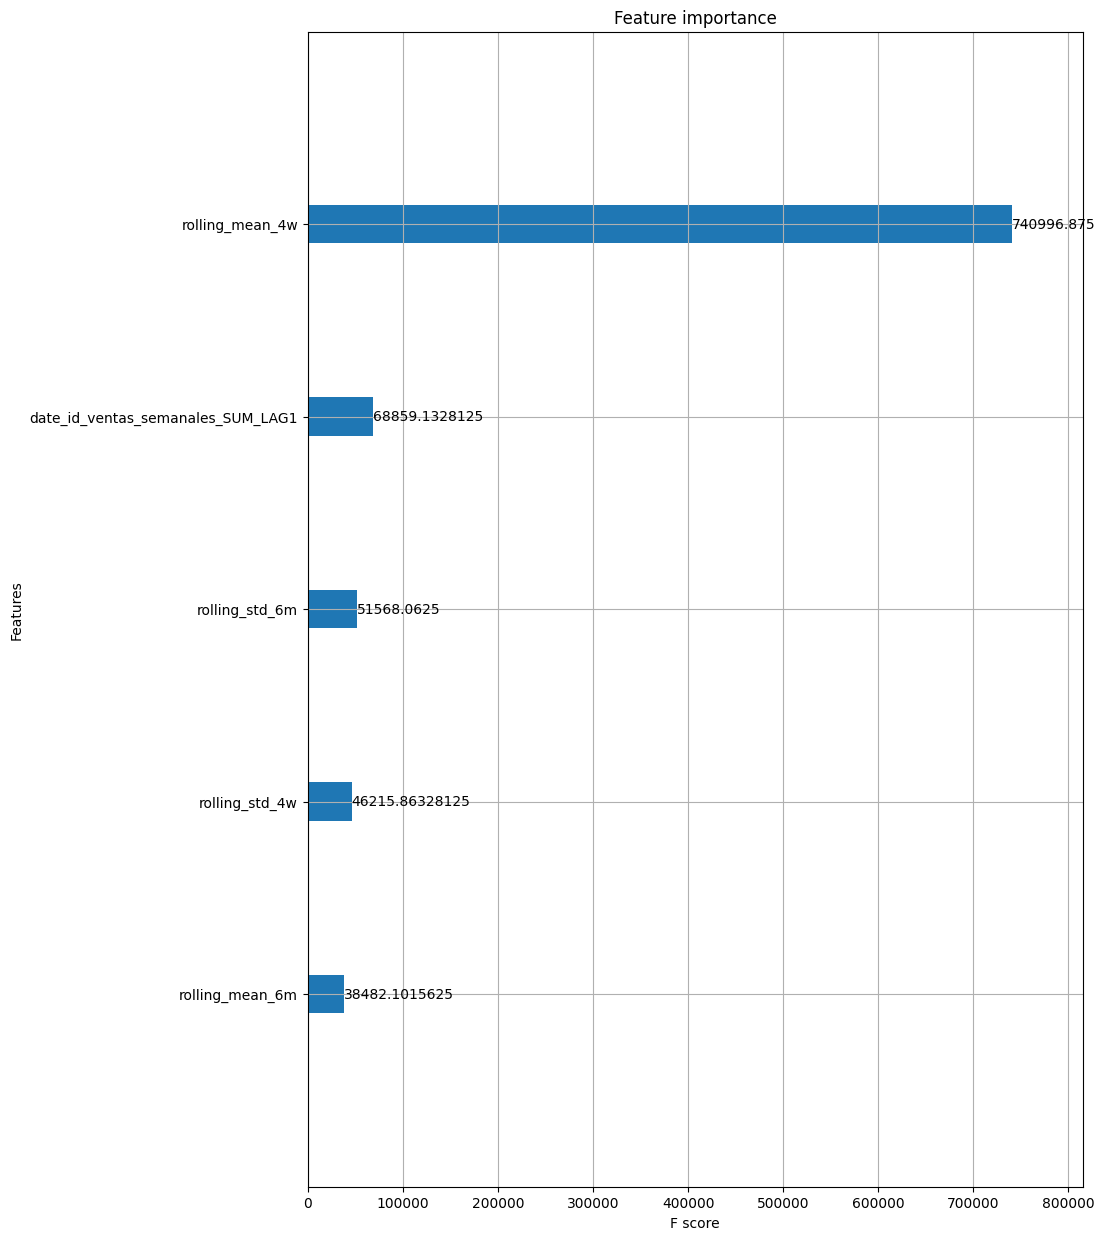

In [101]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

# Prediction

In [102]:
predictions = model.predict(X_valid)

In [103]:
# Añade las predicciones al DataFrame original
full_df.loc[full_df.index.get_level_values('date') == full_df.index.get_level_values('date').max(), 'ventas_semanales'] = predictions

In [104]:
date_to_select = pd.to_datetime('2016-05-01')
selected_rows = full_df.xs(date_to_select, level='date')
selected_rows

ventas_semanales   
item              store_code                     
ACCESORIES_1_001  BOS_1               0.034463  \
                  BOS_2               2.113896   
                  BOS_3               1.649451   
                  NYC_1               6.509677   
                  NYC_2               2.181912   
...                                        ...   
SUPERMARKET_3_827 NYC_3               0.034463   
                  NYC_4              20.632490   
                  PHI_1              16.969145   
                  PHI_2              11.147594   
                  PHI_3               2.583170   

                              date_id_ventas_semanales_SUM_LAG1   
item              store_code                                      
ACCESORIES_1_001  BOS_1                                     0.0  \
                  BOS_2                                     1.0   
                  BOS_3                                     0.0   
                  NYC_1                                     8.0   
                  NYC_2                                     0.0   
...                                                         ...   
SUPERMARKET_3_827 NYC_3                                     0.0   
                  NYC_4                                    22.0   
                  PHI_1                                    15.0   
                  PHI_2                                    12.0   
                  PHI_3                                     0.0   

                              rolling_mean_4w  rolling_mean_6m   
item              store_code                                     
ACCESORIES_1_001  BOS_1                  0.00         0.916667  \
                  BOS_2                  1.00         1.916667   
                  BOS_3                  0.75         2.041667   
                  NYC_1                  6.25         3.083333   
                  NYC_2                  0.50         2.666667   
...                                       ...              ...   
SUPERMARKET_3_827 NYC_3                  0.00        18.500000   
                  NYC_4                  5.50         2.166667   
                  PHI_1                 12.75        12.541667   
                  PHI_2                 12.75         8.666667   
                  PHI_3                  2.00         3.375000   

                              rolling_std_4w  rolling_std_6m  
item              store_code                                  
ACCESORIES_1_001  BOS_1             0.000000        1.059806  
                  BOS_2             1.414214        2.282574  
                  BOS_3             1.500000        2.612331  
                  NYC_1             5.057997        3.549852  
                  NYC_2             1.000000        2.973311  
...                                      ...             ...  
SUPERMARKET_3_827 NYC_3             0.000000       42.934733  
                  NYC_4            11.000000        7.263169  
                  PHI_1            17.036725       15.251455  
                  PHI_2             9.429563        9.521905  
                  PHI_3             4.000000        5.419871  

[30490 rows x 6 columns]

In [105]:
selected_rows['ventas_semanales'].sum()

145893.68385378458

In [106]:
date_to_select = pd.to_datetime('2016-04-24')
selected_rows = full_df.xs(date_to_select, level='date')
selected_rows

ventas_semanales   
item              store_code                     
ACCESORIES_1_001  BOS_1                    0.0  \
                  BOS_2                    1.0   
                  BOS_3                    0.0   
                  NYC_1                    8.0   
                  NYC_2                    0.0   
...                                        ...   
SUPERMARKET_3_827 NYC_3                    0.0   
                  NYC_4                   22.0   
                  PHI_1                   15.0   
                  PHI_2                   12.0   
                  PHI_3                    0.0   

                              date_id_ventas_semanales_SUM_LAG1   
item              store_code                                      
ACCESORIES_1_001  BOS_1                                     0.0  \
                  BOS_2                                     0.0   
                  BOS_3                                     0.0   
                  NYC_1                                     5.0   
                  NYC_2                                     2.0   
...                                                         ...   
SUPERMARKET_3_827 NYC_3                                     0.0   
                  NYC_4                                     0.0   
                  PHI_1                                     0.0   
                  PHI_2                                    17.0   
                  PHI_3                                     0.0   

                              rolling_mean_4w  rolling_mean_6m   
item              store_code                                     
ACCESORIES_1_001  BOS_1                  0.00         0.916667  \
                  BOS_2                  1.75         1.916667   
                  BOS_3                  1.25         2.041667   
                  NYC_1                  6.25         3.250000   
                  NYC_2                  2.00         2.875000   
...                                       ...              ...   
SUPERMARKET_3_827 NYC_3                  0.00        18.500000   
                  NYC_4                 12.75         2.166667   
                  PHI_1                 12.75        13.750000   
                  PHI_2                 12.75         9.375000   
                  PHI_3                  2.00         4.041667   

                              rolling_std_4w  rolling_std_6m  
item              store_code                                  
ACCESORIES_1_001  BOS_1             0.000000        1.059806  
                  BOS_2             1.500000        2.282574  
                  BOS_3             1.500000        2.612331  
                  NYC_1             5.057997        3.492227  
                  NYC_2             2.828427        2.953443  
...                                      ...             ...  
SUPERMARKET_3_827 NYC_3             0.000000       42.934733  
                  NYC_4            14.997222        7.263169  
                  PHI_1            17.036725       15.362999  
                  PHI_2             9.429563        9.481389  
                  PHI_3             4.000000        5.945251  

[30490 rows x 6 columns]

In [107]:
selected_rows['ventas_semanales'].sum()

144476.0

# Prediccion para las siguientes semanas

In [111]:
def add_prediction_weeks(full_df, model, num_weeks):
    # Obtener la última fecha en el DataFrame
    last_date = full_df.index.get_level_values('date').max()

    for i in range(num_weeks):
        # Calcular la nueva fecha
        new_date = last_date + pd.DateOffset(weeks=1)

        # Crear índices para la nueva semana en el DataFrame original
        new_index = pd.MultiIndex.from_product([full_df.index.get_level_values('item').unique(), 
                                                full_df.index.get_level_values('store_code').unique(),
                                                [new_date]],
                                               names=['item', 'store_code', 'date'])

        # Agregar la nueva semana al DataFrame original con valores NaN
        full_df = full_df.reindex(full_df.index.union(new_index))
        
        # Copiar los valores desde la última semana disponible
        full_df.loc[new_index, 'date_id_ventas_semanales_SUM_LAG1'] = full_df.loc[pd.IndexSlice[:, :, last_date], 'date_id_ventas_semanales_SUM_LAG1'].values
        full_df.loc[new_index, 'rolling_mean_4w'] = full_df.loc[pd.IndexSlice[:, :, last_date], 'rolling_mean_4w'].values
        full_df.loc[new_index, 'rolling_mean_6m'] = full_df.loc[pd.IndexSlice[:, :, last_date], 'rolling_mean_6m'].values
        full_df.loc[new_index, 'rolling_std_4w'] = full_df.loc[pd.IndexSlice[:, :, last_date], 'rolling_std_4w'].values
        full_df.loc[new_index, 'rolling_std_6m'] = full_df.loc[pd.IndexSlice[:, :, last_date], 'rolling_std_6m'].values
            
        # Realizar la predicción para la nueva semana
        X_new = full_df.drop('ventas_semanales', axis=1)
        predictions = model.predict(X_new.loc[new_index])

        # Asignar las predicciones a la semana correspondiente en el DataFrame
        full_df.loc[new_index, 'ventas_semanales'] = predictions

        # Actualizar el valor de 'date_id_ventas_semanales_SUM_LAG1_y' para la próxima iteración
        full_df.loc[new_index, 'date_id_ventas_semanales_SUM_LAG1'] = predictions

        # Actualizar last_date para la próxima iteración
        last_date = new_date

    return full_df


In [112]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8384750 entries, ('ACCESORIES_1_001', 'BOS_1', Timestamp('2011-01-30 00:00:00')) to ('SUPERMARKET_3_827', 'PHI_3', Timestamp('2016-05-01 00:00:00'))
Data columns (total 6 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   ventas_semanales                   float64
 1   date_id_ventas_semanales_SUM_LAG1  float64
 2   rolling_mean_4w                    float64
 3   rolling_mean_6m                    float64
 4   rolling_std_4w                     float64
 5   rolling_std_6m                     float64
dtypes: float64(6)
memory usage: 681.9+ MB


In [113]:
full_df = add_prediction_weeks(full_df,model,3)

In [114]:
#full_df['ventas_semanales'] = full_df['ventas_semanales'].round()

In [115]:
date_to_select = pd.to_datetime('2016-05-08')
selected_rows = full_df.xs(date_to_select, level='date')
selected_rows

ventas_semanales   
item              store_code                     
ACCESORIES_1_001  BOS_1               0.034463  \
                  BOS_2               1.028380   
                  BOS_3               1.013126   
                  NYC_1               5.662488   
                  NYC_2               0.653014   
...                                        ...   
SUPERMARKET_3_827 NYC_3               0.034463   
                  NYC_4               0.851301   
                  PHI_1              11.710000   
                  PHI_2              12.375142   
                  PHI_3               2.583170   

                              date_id_ventas_semanales_SUM_LAG1   
item              store_code                                      
ACCESORIES_1_001  BOS_1                                0.034463  \
                  BOS_2                                1.028380   
                  BOS_3                                1.013126   
                  NYC_1                                5.662488   
                  NYC_2                                0.653014   
...                                                         ...   
SUPERMARKET_3_827 NYC_3                                0.034463   
                  NYC_4                                0.851301   
                  PHI_1                               11.710000   
                  PHI_2                               12.375142   
                  PHI_3                                2.583170   

                              rolling_mean_4w  rolling_mean_6m   
item              store_code                                     
ACCESORIES_1_001  BOS_1                  0.00         0.916667  \
                  BOS_2                  1.00         1.916667   
                  BOS_3                  0.75         2.041667   
                  NYC_1                  6.25         3.083333   
                  NYC_2                  0.50         2.666667   
...                                       ...              ...   
SUPERMARKET_3_827 NYC_3                  0.00        18.500000   
                  NYC_4                  5.50         2.166667   
                  PHI_1                 12.75        12.541667   
                  PHI_2                 12.75         8.666667   
                  PHI_3                  2.00         3.375000   

                              rolling_std_4w  rolling_std_6m  
item              store_code                                  
ACCESORIES_1_001  BOS_1             0.000000        1.059806  
                  BOS_2             1.414214        2.282574  
                  BOS_3             1.500000        2.612331  
                  NYC_1             5.057997        3.549852  
                  NYC_2             1.000000        2.973311  
...                                      ...             ...  
SUPERMARKET_3_827 NYC_3             0.000000       42.934733  
                  NYC_4            11.000000        7.263169  
                  PHI_1            17.036725       15.251455  
                  PHI_2             9.429563        9.521905  
                  PHI_3             4.000000        5.419871  

[30490 rows x 6 columns]

In [116]:
selected_rows['ventas_semanales'].sum()

100829.65734066628

In [117]:
date_to_select = pd.to_datetime('2016-05-15')
selected_rows = full_df.xs(date_to_select, level='date')
selected_rows

ventas_semanales   
item              store_code                     
ACCESORIES_1_001  BOS_1               0.034463  \
                  BOS_2               1.028380   
                  BOS_3               0.622393   
                  NYC_1               6.299986   
                  NYC_2               0.367040   
...                                        ...   
SUPERMARKET_3_827 NYC_3               0.034463   
                  NYC_4               7.240319   
                  PHI_1              12.530944   
                  PHI_2              12.375142   
                  PHI_3               2.125816   

                              date_id_ventas_semanales_SUM_LAG1   
item              store_code                                      
ACCESORIES_1_001  BOS_1                                0.034463  \
                  BOS_2                                1.028380   
                  BOS_3                                0.622393   
                  NYC_1                                6.299986   
                  NYC_2                                0.367040   
...                                                         ...   
SUPERMARKET_3_827 NYC_3                                0.034463   
                  NYC_4                                7.240319   
                  PHI_1                               12.530944   
                  PHI_2                               12.375142   
                  PHI_3                                2.125816   

                              rolling_mean_4w  rolling_mean_6m   
item              store_code                                     
ACCESORIES_1_001  BOS_1                  0.00         0.916667  \
                  BOS_2                  1.00         1.916667   
                  BOS_3                  0.75         2.041667   
                  NYC_1                  6.25         3.083333   
                  NYC_2                  0.50         2.666667   
...                                       ...              ...   
SUPERMARKET_3_827 NYC_3                  0.00        18.500000   
                  NYC_4                  5.50         2.166667   
                  PHI_1                 12.75        12.541667   
                  PHI_2                 12.75         8.666667   
                  PHI_3                  2.00         3.375000   

                              rolling_std_4w  rolling_std_6m  
item              store_code                                  
ACCESORIES_1_001  BOS_1             0.000000        1.059806  
                  BOS_2             1.414214        2.282574  
                  BOS_3             1.500000        2.612331  
                  NYC_1             5.057997        3.549852  
                  NYC_2             1.000000        2.973311  
...                                      ...             ...  
SUPERMARKET_3_827 NYC_3             0.000000       42.934733  
                  NYC_4            11.000000        7.263169  
                  PHI_1            17.036725       15.251455  
                  PHI_2             9.429563        9.521905  
                  PHI_3             4.000000        5.419871  

[30490 rows x 6 columns]

In [118]:
selected_rows['ventas_semanales'].sum()

110910.00591249019

In [119]:
date_to_select = pd.to_datetime('2016-05-15')
selected_rows = full_df.xs(date_to_select, level='date')
selected_rows

ventas_semanales   
item              store_code                     
ACCESORIES_1_001  BOS_1               0.034463  \
                  BOS_2               1.028380   
                  BOS_3               0.622393   
                  NYC_1               6.299986   
                  NYC_2               0.367040   
...                                        ...   
SUPERMARKET_3_827 NYC_3               0.034463   
                  NYC_4               7.240319   
                  PHI_1              12.530944   
                  PHI_2              12.375142   
                  PHI_3               2.125816   

                              date_id_ventas_semanales_SUM_LAG1   
item              store_code                                      
ACCESORIES_1_001  BOS_1                                0.034463  \
                  BOS_2                                1.028380   
                  BOS_3                                0.622393   
                  NYC_1                                6.299986   
                  NYC_2                                0.367040   
...                                                         ...   
SUPERMARKET_3_827 NYC_3                                0.034463   
                  NYC_4                                7.240319   
                  PHI_1                               12.530944   
                  PHI_2                               12.375142   
                  PHI_3                                2.125816   

                              rolling_mean_4w  rolling_mean_6m   
item              store_code                                     
ACCESORIES_1_001  BOS_1                  0.00         0.916667  \
                  BOS_2                  1.00         1.916667   
                  BOS_3                  0.75         2.041667   
                  NYC_1                  6.25         3.083333   
                  NYC_2                  0.50         2.666667   
...                                       ...              ...   
SUPERMARKET_3_827 NYC_3                  0.00        18.500000   
                  NYC_4                  5.50         2.166667   
                  PHI_1                 12.75        12.541667   
                  PHI_2                 12.75         8.666667   
                  PHI_3                  2.00         3.375000   

                              rolling_std_4w  rolling_std_6m  
item              store_code                                  
ACCESORIES_1_001  BOS_1             0.000000        1.059806  
                  BOS_2             1.414214        2.282574  
                  BOS_3             1.500000        2.612331  
                  NYC_1             5.057997        3.549852  
                  NYC_2             1.000000        2.973311  
...                                      ...             ...  
SUPERMARKET_3_827 NYC_3             0.000000       42.934733  
                  NYC_4            11.000000        7.263169  
                  PHI_1            17.036725       15.251455  
                  PHI_2             9.429563        9.521905  
                  PHI_3             4.000000        5.419871  

[30490 rows x 6 columns]

In [120]:
selected_rows['ventas_semanales'].sum()

110910.00591249019

In [121]:
full_df['ventas_semanales'] = full_df['ventas_semanales'].astype(int)

In [122]:
full_df.to_csv('DSMarketPrediction2.csv', index=True)

# Evaluar el modelo 

In [123]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calcular Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_valid, predictions)
print(f'MAE: {mae}')

# Calcular Mean Squared Error (MSE)
mse = mean_squared_error(Y_valid, predictions)
print(f'MSE: {mse}')

# Calcular Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calcular R-squared
r2 = r2_score(Y_valid, predictions)
print(f'R^2: {r2}')

MAE: 3.5951689195895256
MSE: 90.22074764474928
RMSE: 9.498460277579166
R^2: 0.6331382859795904


# Extracción de datos para predicción

In [124]:
# Ordenamos por fecha
full_df.sort_index(level='date', inplace=True)

# Obtenemos la fecha máxima
last_date = full_df.index.get_level_values('date').max()

# Calcula la fecha hace 3 semanas
four_weeks_ago = last_date - pd.DateOffset(weeks=3)

# Selecciona solo las filas de las últimas 4 semanas
last_four_weeks_df = full_df[full_df.index.get_level_values('date') >= four_weeks_ago]

Reorganización de datos

In [125]:
last_four_weeks_df = last_four_weeks_df.reset_index()

last_four_weeks_df['date'].unique()

<DatetimeArray>
['2016-05-01 00:00:00', '2016-05-08 00:00:00', '2016-05-15 00:00:00',
 '2016-05-22 00:00:00']
Length: 4, dtype: datetime64[ns]

In [126]:
pivot_df = last_four_weeks_df.pivot(index=['item', 'store_code'], columns='date', values='ventas_semanales')

In [127]:
pivot_df.sample(2)

,date,2016-05-01,2016-05-08,2016-05-15,2016-05-22
item,store_code,,,,
HOME_&_GARDEN_2_301,BOS_1,0,0,0,0
SUPERMARKET_1_118,BOS_3,1,0,1,0


In [128]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30490 entries, ('ACCESORIES_1_001', 'BOS_1') to ('SUPERMARKET_3_827', 'PHI_3')
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   2016-05-01 00:00:00  30490 non-null  int64
 1   2016-05-08 00:00:00  30490 non-null  int64
 2   2016-05-15 00:00:00  30490 non-null  int64
 3   2016-05-22 00:00:00  30490 non-null  int64
dtypes: int64(4)
memory usage: 1.1+ MB


In [129]:
# Guarda el resultado en un archivo CSV
pivot_df.to_csv('last_four_weeks.csv')

In [130]:
full_df['ventas_semanales'].sum()
#32822341

33245372

In [131]:
full_df_test = full_df.reset_index()

full_df_test['date'].unique()

<DatetimeArray>
['2011-01-30 00:00:00', '2011-02-06 00:00:00', '2011-02-13 00:00:00',
 '2011-02-20 00:00:00', '2011-02-27 00:00:00', '2011-03-06 00:00:00',
 '2011-03-13 00:00:00', '2011-03-20 00:00:00', '2011-03-27 00:00:00',
 '2011-04-03 00:00:00',
 ...
 '2016-03-20 00:00:00', '2016-03-27 00:00:00', '2016-04-03 00:00:00',
 '2016-04-10 00:00:00', '2016-04-17 00:00:00', '2016-04-24 00:00:00',
 '2016-05-01 00:00:00', '2016-05-08 00:00:00', '2016-05-15 00:00:00',
 '2016-05-22 00:00:00']
Length: 278, dtype: datetime64[ns]

In [132]:
date_to_select = pd.to_datetime('2016-03-20')
selected_rows = full_df.xs(date_to_select, level='date')
selected_rows

ventas_semanales   
item              store_code                     
ACCESORIES_1_001  BOS_1                      2  \
                  BOS_2                      0   
                  BOS_3                      0   
                  NYC_1                      0   
                  NYC_2                      6   
...                                        ...   
SUPERMARKET_3_827 NYC_3                      0   
                  NYC_4                      0   
                  PHI_1                     36   
                  PHI_2                      0   
                  PHI_3                     15   

                              date_id_ventas_semanales_SUM_LAG1   
item              store_code                                      
ACCESORIES_1_001  BOS_1                                     3.0  \
                  BOS_2                                     1.0   
                  BOS_3                                     0.0   
                  NYC_1                                     5.0   
                  NYC_2                                     6.0   
...                                                         ...   
SUPERMARKET_3_827 NYC_3                                     0.0   
                  NYC_4                                     0.0   
                  PHI_1                                    39.0   
                  PHI_2                                    29.0   
                  PHI_3                                     0.0   

                              rolling_mean_4w  rolling_mean_6m   
item              store_code                                     
ACCESORIES_1_001  BOS_1                  1.75         1.083333  \
                  BOS_2                  1.00         1.791667   
                  BOS_3                  0.75         2.041667   
                  NYC_1                  2.50         2.625000   
                  NYC_2                  5.50         2.541667   
...                                       ...              ...   
SUPERMARKET_3_827 NYC_3                 41.75        20.416667   
                  NYC_4                  0.25         0.041667   
                  PHI_1                 34.50        13.250000   
                  PHI_2                 12.50         7.291667   
                  PHI_3                  3.75         5.250000   

                              rolling_std_4w  rolling_std_6m  
item              store_code                                  
ACCESORIES_1_001  BOS_1             1.258306        1.100066  
                  BOS_2             0.816497        2.358687  
                  BOS_3             1.500000        2.595635  
                  NYC_1             2.886751        2.731658  
                  NYC_2             0.577350        2.977877  
...                                      ...             ...  
SUPERMARKET_3_827 NYC_3            83.500000       42.660354  
                  NYC_4             0.500000        0.204124  
                  PHI_1             5.196152       15.311973  
                  PHI_2            14.798649        9.341256  
                  PHI_3             7.500000        7.236682  

[30490 rows x 6 columns]

In [133]:
selected_rows['ventas_semanales'].sum()


146585

In [134]:
pivot_df['2016-05-01'].sum()

134441

In [135]:
date_to_select = pd.to_datetime('2016-05-01')
selected_rows = full_df.xs(date_to_select, level='date')
selected_rows

ventas_semanales   
item              store_code                     
ACCESORIES_1_001  BOS_1                      0  \
                  BOS_2                      2   
                  BOS_3                      1   
                  NYC_1                      6   
                  NYC_2                      2   
...                                        ...   
SUPERMARKET_3_827 NYC_3                      0   
                  NYC_4                     20   
                  PHI_1                     16   
                  PHI_2                     11   
                  PHI_3                      2   

                              date_id_ventas_semanales_SUM_LAG1   
item              store_code                                      
ACCESORIES_1_001  BOS_1                                     0.0  \
                  BOS_2                                     1.0   
                  BOS_3                                     0.0   
                  NYC_1                                     8.0   
                  NYC_2                                     0.0   
...                                                         ...   
SUPERMARKET_3_827 NYC_3                                     0.0   
                  NYC_4                                    22.0   
                  PHI_1                                    15.0   
                  PHI_2                                    12.0   
                  PHI_3                                     0.0   

                              rolling_mean_4w  rolling_mean_6m   
item              store_code                                     
ACCESORIES_1_001  BOS_1                  0.00         0.916667  \
                  BOS_2                  1.00         1.916667   
                  BOS_3                  0.75         2.041667   
                  NYC_1                  6.25         3.083333   
                  NYC_2                  0.50         2.666667   
...                                       ...              ...   
SUPERMARKET_3_827 NYC_3                  0.00        18.500000   
                  NYC_4                  5.50         2.166667   
                  PHI_1                 12.75        12.541667   
                  PHI_2                 12.75         8.666667   
                  PHI_3                  2.00         3.375000   

                              rolling_std_4w  rolling_std_6m  
item              store_code                                  
ACCESORIES_1_001  BOS_1             0.000000        1.059806  
                  BOS_2             1.414214        2.282574  
                  BOS_3             1.500000        2.612331  
                  NYC_1             5.057997        3.549852  
                  NYC_2             1.000000        2.973311  
...                                      ...             ...  
SUPERMARKET_3_827 NYC_3             0.000000       42.934733  
                  NYC_4            11.000000        7.263169  
                  PHI_1            17.036725       15.251455  
                  PHI_2             9.429563        9.521905  
                  PHI_3             4.000000        5.419871  

[30490 rows x 6 columns]

In [136]:
selected_rows['ventas_semanales'].sum()

134441